In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# Data Processing Libraries
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus
from string import punctuation
from bs4 import BeautifulSoup

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, precision_score, recall_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Text Cleaning Function
def clean_text(text):
    token = ToktokTokenizer()
    lemma = WordNetLemmatizer()
    stop_words = set(corpus.stopwords.words("english"))
    punct = punctuation

    text = str(text).lower().strip()
    text = BeautifulSoup(text, "html.parser").get_text()
    words = token.tokenize(text)
    words = [lemma.lemmatize(w) for w in words if w not in stop_words and w not in punct]
    return ' '.join(words)

# Prepare Data for Deep Learning
def prepare_data_for_dl(question_df, max_words=5000, max_len=200):
    # Prepare text
    texts = question_df['Text'].values

    # Tokenize text
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

    # Prepare labels
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(question_df['Tags'])

    return padded_sequences, y, tokenizer, mlb



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Download dataset
path = kagglehub.dataset_download("stackoverflow/stacksample")
print("Path to dataset files:", path)

# Construct file paths
questions_path = os.path.join(path, 'Questions.csv')
tags_path = os.path.join(path, 'Tags.csv')

# Data Loading
question_df = pd.read_csv(questions_path, encoding="ISO-8859-1")
tag_df = pd.read_csv(tags_path, encoding="ISO-8859-1", dtype={'Tag': str})

tag_df['Tag'] = tag_df['Tag'].astype(str)
grouped_tags = tag_df.groupby("Id")['Tag'].apply(lambda tag_df: ' '.join(tag_df))
grouped_tags_final = pd.DataFrame({'Id': grouped_tags.index, 'Tags': grouped_tags.values})

question_df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
question_df = question_df.merge(grouped_tags_final, on='Id')

# Filter high-score questions
question_df = question_df[question_df['Score'] > 5]
question_df.drop(columns=['Id', 'Score'], inplace=True)

# Clean and Prepare Tags
question_df['Tags'] = question_df['Tags'].apply(lambda x: str(x).split(', '))
flat_list = [item for sublist in question_df['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
tags_features = [word[0] for word in keywords.most_common(10)]

def most_common(tags):
    return [tag for tag in tags if tag in tags_features]

question_df['Tags'] = question_df['Tags'].apply(lambda x: most_common(x))
question_df['Tags'] = question_df['Tags'].apply(lambda x: x if len(x) > 0 else None)
question_df.dropna(subset=['Tags'], inplace=True)

# Parameters
MAX_WORDS = 5000
MAX_LEN = 200

Path to dataset files: /root/.cache/kagglehub/datasets/stackoverflow/stacksample/versions/2


In [ ]:
print(question_df.head())

                                                 Title  \
205          Code to ask yes/no question in javascript   
223       Table cells larger than they are meant to be   
377  What is the best quick-read Python book out th...   
379                      duplicating jQuery datepicker   
471                        Writing/Using C++ Libraries   

                                                  Body                 Tags  
205  <p>I could only find the function <code>confir...         [javascript]  
223  <p>I've created a map system for a game that r...           [html css]  
377  <p>I am taking a class that requires Python. W...             [python]  
379  <p>The <code>datepicker</code> function only w...  [javascript jquery]  
471  <p>I am looking for basic examples/tutorials o...                [c++]  


In [ ]:
# Text Cleaning
nltk.download('stopwords')
nltk.download('wordnet')

token = ToktokTokenizer()
punct = punctuation
lemma = WordNetLemmatizer()
stop_words = set(corpus.stopwords.words("english"))

def clean_text(text):
    text = text.lower().strip()
    text = BeautifulSoup(text, "html.parser").get_text()
    words = token.tokenize(text)
    words = [lemma.lemmatize(w) for w in words if w not in stop_words and w not in punct]
    return ' '.join(words)

question_df['Body'] = question_df['Body'].apply(clean_text)
question_df['Title'] = question_df['Title'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-7-1ebba17c1382>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Vectorization
X1 = question_df['Body']
X2 = question_df['Title']
y = question_df['Tags']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

vectorizer_X1 = TfidfVectorizer(max_features=1000)
vectorizer_X2 = TfidfVectorizer(max_features=1000)

X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)
X_tfidf = hstack([X1_tfidf, X2_tfidf])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size=0.2, random_state=0)

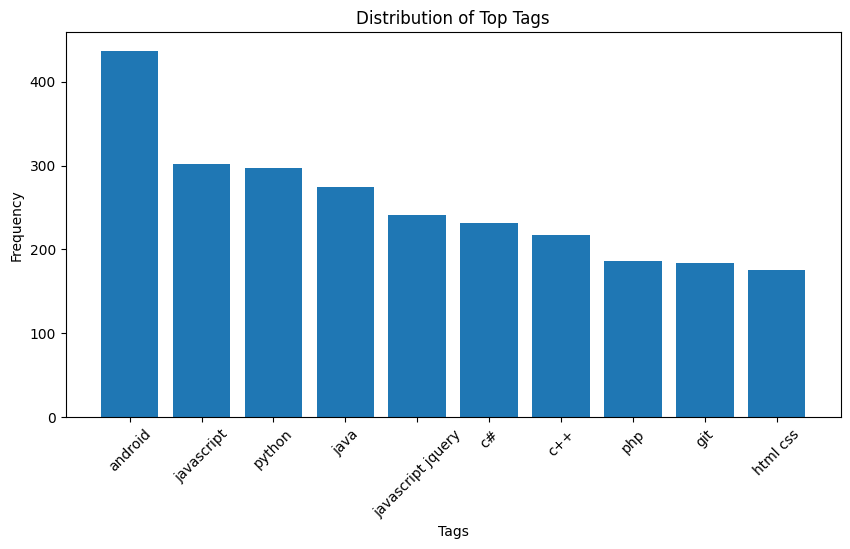

In [ ]:
# Calculate tag counts directly for the filtered top tags
tag_counts = dict(zip(multilabel_binarizer.classes_, y_bin.sum(axis=0)))

# Only include the top tags from tags_features
top_tag_counts = {tag: tag_counts.get(tag, 0) for tag in tags_features}

# Plot Distribution of Top Tags
plt.figure(figsize=(10, 5))
plt.bar(top_tag_counts.keys(), top_tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Top Tags')
plt.xticks(rotation=45)
plt.show()

# Test new code

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.1153 - loss: 0.5279 - val_accuracy: 0.1838 - val_loss: 0.3285
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.1358 - loss: 0.3573 - val_accuracy: 0.1838 - val_loss: 0.3267
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - accuracy: 0.1311 - loss: 0.3423 - val_accuracy: 0.1838 - val_loss: 0.3294
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.1725 - loss: 0.3270 - val_accuracy: 0.2598 - val_loss: 0.3001
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 474ms/step - accuracy: 0.2720 - loss: 0.2878 - val_accuracy: 0.3039 - val_loss: 0.2729
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 464ms/step - accuracy: 0.3309 - loss: 0.2665 - val_accuracy: 0.3382 - val_loss: 0.2644
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.4108 - loss: 0.2392 - val_accuracy: 0.3750 - val_loss: 0.2429
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - accuracy: 0.4657 - loss: 0.2166 - val_accuracy: 0.522

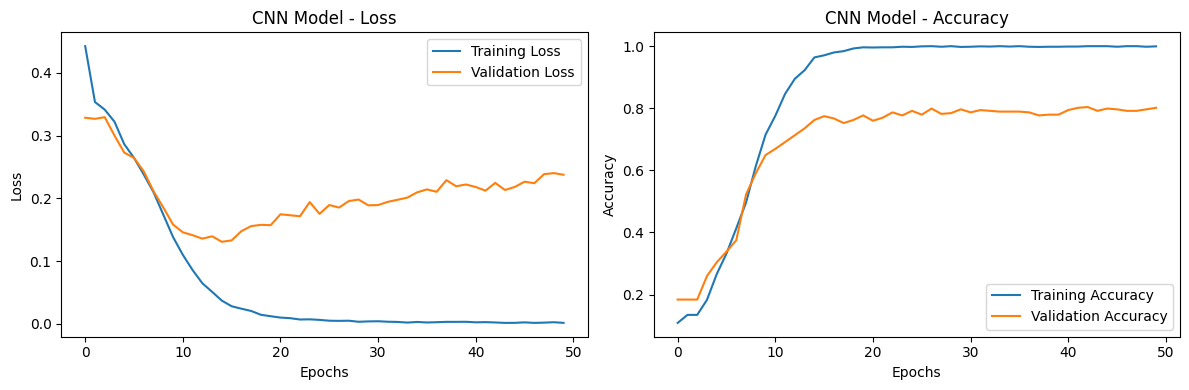

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# Data Processing Libraries
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus
from string import punctuation
from bs4 import BeautifulSoup

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Text Preprocessing
max_words = 10000  # Maximum number of words to keep
max_len = 200      # Maximum length of each sequence

# Create Keras Tokenizer
keras_tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
keras_tokenizer.fit_on_texts(question_df['Body'] + ' ' + question_df['Title'])

# Convert text to sequences
X1_seq = keras_tokenizer.texts_to_sequences(question_df['Body'])
X2_seq = keras_tokenizer.texts_to_sequences(question_df['Title'])

# Pad sequences
X1_pad = pad_sequences(X1_seq, maxlen=max_len, padding='post', truncating='post')
X2_pad = pad_sequences(X2_seq, maxlen=max_len, padding='post', truncating='post')

# Combine padded sequences
X_pad = np.concatenate([X1_pad, X2_pad], axis=1)

# Split data
X_train_pad, X_test_pad, y_train, y_test = train_test_split(
    X_pad, y_bin, test_size=0.2, random_state=42
)

# Training and Evaluation Function
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Early Stopping
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     restore_best_weights=True
    # )

    # Train Model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        # callbacks=[early_stopping]
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Evaluation Metrics
    hamming = hamming_loss(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, average='macro')
    recall = recall_score(y_test, y_pred_binary, average='macro')
    f1 = f1_score(y_test, y_pred_binary, average='macro')

    print(f"{model_name} Model Metrics:")
    print(f"Hamming Loss: {hamming}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # add precision to history
    history.history['precision'] = [precision]
    history.history['recall'] = [recall]
    history.history['f1'] = [f1]

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return history

from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

def create_cnn_model(num_classes=len(tags_features)):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=max_words,
                        output_dim=128,
                        input_length=X_train_pad.shape[1]))
    model.add(Dropout(0.3))

    # Convolution + MaxPooling Layers
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



cnn_model = create_cnn_model()
cnn_history = train_and_evaluate_model(
    cnn_model,
    X_train_pad,
    X_test_pad,
    y_train,
    y_test,
    "CNN"
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 552ms/step - accuracy: 0.1011 - loss: 0.5760 - val_accuracy: 0.1838 - val_loss: 0.3284
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 538ms/step - accuracy: 0.1024 - loss: 0.4066 - val_accuracy: 0.1838 - val_loss: 0.3668
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.1195 - loss: 0.3727 - val_accuracy: 0.1838 - val_loss: 0.3336
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.1030 - loss: 0.3632 - val_accuracy: 0.1838 - val_loss: 0.3384
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 536ms/step - accuracy: 0.1206 - loss: 0.3580 - val_accuracy: 0.1838 - val_loss: 0.3272
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - accuracy: 0.1281 - loss: 0.3547 - val_accuracy: 0.1838 - val_loss: 0.3236
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 537ms/step - accuracy: 0.1620 - loss: 0.3459 - val_accuracy: 0.1838 - val_loss: 0.3040
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - accuracy: 0.2354 - loss: 0.3114 - val_accu

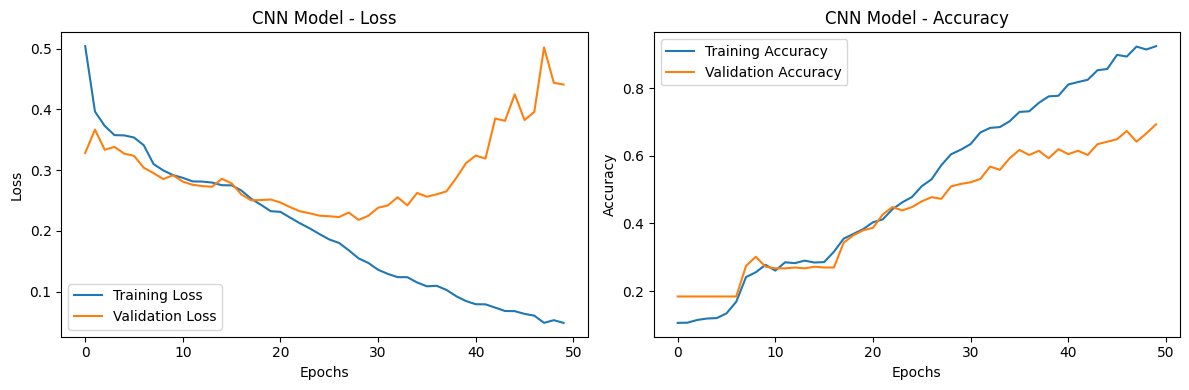

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def create_cnn_model2(num_classes=len(tags_features)):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=max_words,
                        output_dim=128,
                        input_length=X_train_pad.shape[1]))
    model.add(Dropout(0.3))

    # First Convolution + MaxPooling Layer
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))

    # Second Convolution Layer
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    # Third Convolution Layer
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    # Fourth Convolution Layer
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    # Global Max Pooling Layer
    model.add(GlobalMaxPooling1D())

    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Another Dense Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model




cnn_model2 = create_cnn_model2()
cnn_history2 = train_and_evaluate_model(
    cnn_model2,
    X_train_pad,
    X_test_pad,
    y_train,
    y_test,
    "CNN"
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step - accuracy: 0.1024 - loss: 0.5787 - val_accuracy: 0.2206 - val_loss: 0.3273
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.1880 - loss: 0.3323 - val_accuracy: 0.2941 - val_loss: 0.2833
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - accuracy: 0.3279 - loss: 0.2751 - val_accuracy: 0.4828 - val_loss: 0.2277
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.4797 - loss: 0.2181 - val_accuracy: 0.4975 - val_loss: 0.2040
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 475ms/step - accuracy: 0.5766 - loss: 0.1819 - val_accuracy: 0.5368 - val_loss: 0.1871
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.6581 - loss: 0.1504 - val_accuracy: 0.6250 - val_loss: 0.1842
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7108 - loss: 0.1386 - val_accuracy: 0.6520 - val_loss: 0.1701
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 473ms/step - accuracy: 0.7616 - loss: 0.1190 - val_accuracy: 0.698

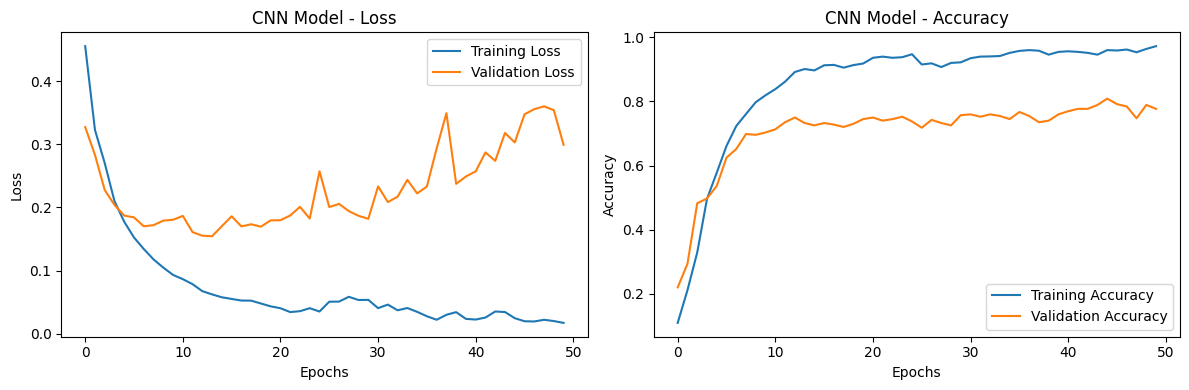

In [ ]:
def create_cnn_model3(num_classes=len(tags_features)):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=max_words,
                        output_dim=128,
                        input_length=X_train_pad.shape[1]))
    model.add(Dropout(0.3))

    # Convolution + MaxPooling Layers
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the Model
    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

cnn_model3 = create_cnn_model3()
cnn_history3 = train_and_evaluate_model(
    cnn_model3,
    X_train_pad,
    X_test_pad,
    y_train,
    y_test,
    "CNN"
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - accuracy: 0.0901 - loss: 0.6006 - val_accuracy: 0.0907 - val_loss: 0.3411
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.1238 - loss: 0.3760 - val_accuracy: 0.1961 - val_loss: 0.3384
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 481ms/step - accuracy: 0.1159 - loss: 0.3647 - val_accuracy: 0.1838 - val_loss: 0.3360
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 475ms/step - accuracy: 0.1115 - loss: 0.3586 - val_accuracy: 0.1838 - val_loss: 0.3340
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.1366 - loss: 0.3532 - val_accuracy: 0.1838 - val_loss: 0.3269
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 472ms/step - accuracy: 0.1377 - loss: 0.3479 - val_accuracy: 0.1838 - val_loss: 0.3315
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - accuracy: 0.1169 - loss: 0.3463 - val_accuracy: 0.1838 - val_loss: 0.3304
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.1643 - loss: 0.3345 - val_accuracy: 0.269

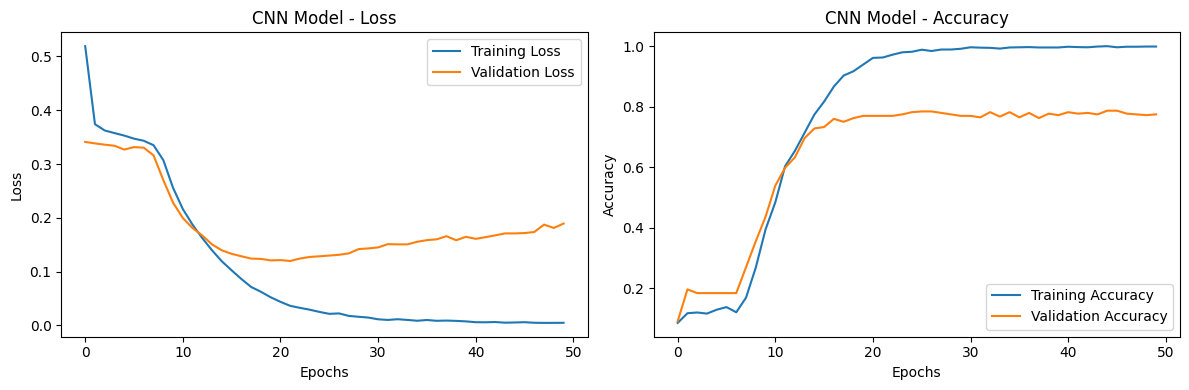

In [ ]:
def create_cnn_model4(num_classes=len(tags_features)):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=max_words,
                        output_dim=128,
                        input_length=X_train_pad.shape[1]))
    model.add(Dropout(0.3))

    # Convolution + MaxPooling Layers
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the Model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

cnn_model4 = create_cnn_model4()
cnn_history4 = train_and_evaluate_model(
    cnn_model4,
    X_train_pad,
    X_test_pad,
    y_train,
    y_test,
    "CNN"
)

In [ ]:
def display_predictions(model, X_test, y_test, multilabel_binarizer):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Decode predictions and true labels
    true_tags = multilabel_binarizer.inverse_transform(y_test)
    pred_tags = multilabel_binarizer.inverse_transform(y_pred_binary)

    # Convert test sequences back to text for context
    word_index = keras_tokenizer.word_index
    reverse_word_index = {v: k for k, v in word_index.items()}

    def sequence_to_text(sequence):
        # Take first half (body) and second half (title)
        mid = len(sequence) // 2
        body_seq = sequence[:mid]
        title_seq = sequence[mid:]

        # Convert sequences back to text
        body_words = [reverse_word_index.get(i, '?') for i in body_seq if i != 0]
        title_words = [reverse_word_index.get(i, '?') for i in title_seq if i != 0]

        return {
            'body': ' '.join(body_words),
            'title': ' '.join(title_words)
        }

    # Display results
    print("\nSample Predictions:")
    print("-" * 50)

    # Display first 5 predictions
    for i in range(5):
        text = sequence_to_text(X_test[i])
        print(f"\nExample {i+1}:")
        print("Title: " + text['title'])
        print("Body: " + text['body'][:200] + "...")  # Truncate body for readability
        print("\nTrue Tags:     ", true_tags[i])
        print("Predicted Tags:", pred_tags[i])
        print("-" * 50)

    return true_tags, pred_tags


print("\n\nCNN Model Predictions:")
cnn_true_tags, cnn_pred_tags = display_predictions(cnn_model, X_test_pad, y_test, multilabel_binarizer)







CNN Model Predictions:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

Sample Predictions:
--------------------------------------------------

Example 1:
Title: javascript accessing private member variable prototype defined function
Body: way make private variable defined constructor available prototype defined method testclass function var privatefield hello this nonprotohello function alert privatefield testclass prototype prototypeh...

True Tags:      ('javascript',)
Predicted Tags: ()
--------------------------------------------------

Example 2:
Title: month name month number vice versa python
Body: trying create function convert month number abbreviated month name abbreviated month name month number thought might common question could find online thinking calendar module see convert month number...

True Tags:      ('python',)
Predicted Tags: ('python',)
--------------------------------------------------

Example 3:
Title: firefox invokes settimeout function soon date gettime
Body: r

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.1069 - loss: 1.1355 - val_accuracy: 0.0613 - val_loss: 0.6410
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.1127 - loss: 0.4207 - val_accuracy: 0.0931 - val_loss: 0.5875
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.1101 - loss: 0.3911 - val_accuracy: 0.0637 - val_loss: 0.5489
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.1239 - loss: 0.3794 - val_accuracy: 0.0613 - val_loss: 0.5158
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.1213 - loss: 0.3716 - val_accuracy: 0.0613 - val_loss: 0.4795
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.1170 - loss: 0.3695 - val_accuracy: 0.0613 - val_loss: 0.4729
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 475ms/step - accuracy: 0.1499 - loss: 0.3565 - val_accuracy: 0.0613 - val_loss: 0.4553
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - accuracy: 0.1649 - loss: 0.3525 - val_accu

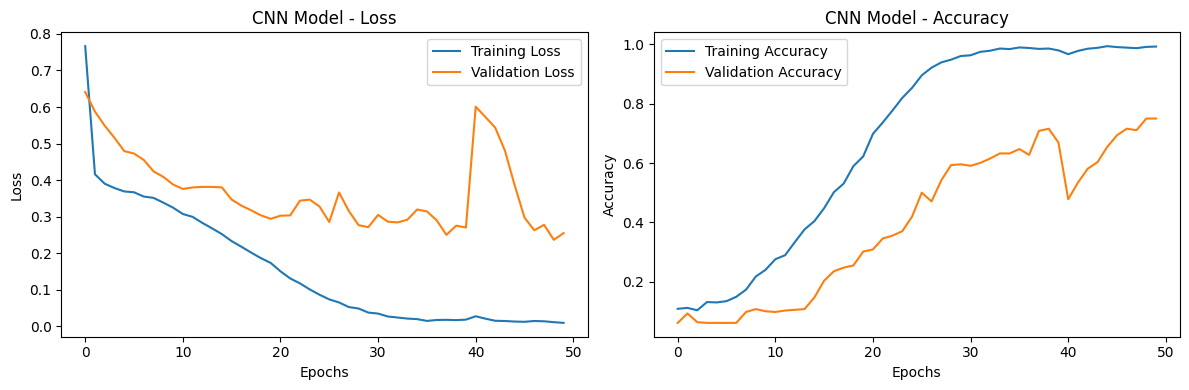

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def create_cnn_model5(num_classes = len(tags_features)):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=max_words,
                        output_dim=128,
                        input_length=X_train_pad.shape[1]))
    model.add(Dropout(0.2))  # Lower Dropout

    # First Convolution + MaxPooling Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))  # smaller kernel
    model.add(BatchNormalization())  # add Batch Normalization
    model.add(MaxPooling1D(pool_size=4))  # larger pool_size

    # Second Convolution Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    # Third Convolution Layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    # Fourth Convolution Layer
    model.add(MaxPooling1D(pool_size=4))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    # Global Max Pooling Layer
    model.add(GlobalMaxPooling1D())

    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # add Dropout

    # Another Dense Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # low lr
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


model5 = create_cnn_model5()
cnn_history5 = train_and_evaluate_model(
    model5,
    X_train_pad,
    X_test_pad,
    y_train,
    y_test,
    "CNN"
)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['val_accuracy'], label='CNN Model 1')
plt.plot(cnn_history2.history['val_accuracy'], label='CNN Model 2')
plt.plot(cnn_history3.history['val_accuracy'], label='CNN Model 3')
plt.plot(cnn_history4.history['val_accuracy'], label='CNN Model 4')
plt.plot(cnn_history5.history['val_accuracy'], label='CNN Model 5')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()



Plot in cnn.png

                        Model1       Model2      Model3    Model4   Model5

Convolution Layer #:     2           4           2         2         4

learning rate:           0.001       0.001       0.01      0.0005    0.001

kernel size:             5           5           5         5         3

max pool size:           5           5           5         5         4

Drop out:           [0.3,0.3]  [0.3,0.5,0.5]  [0.3,0.3] [0.3,0.3] [0.2,0.5,0.5]
